[Chapter 4] Building an LLM - LLM Architecture

In [33]:
GPT_CONFIG_124M = {
    "vocab_size":     50257,     # vocabulary size (by BPE tokenizer)
    "context_length": 1024,      # context length (max token size model can handle)
    "emb_dim":        768,       # embedding dimension (tranform each token into a 768-dimensional vector)
    "n_heads":        12,        # number of head attentions (num of attention heads in the multi-head attention mechanism)
    "n_layers":       12,        # number of layers (num of transformer blocks in the model)
    "drop_rate":      0.1,       # dropout rate (the intensity of dropout mechanism to prevent overfitting)
    "qkv_bias":       False      # query-key-value bias (whether to include a bias vector in the linear layers of the mha)
}

In [34]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # token embeddings
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        # positional embeddings
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        # dropout
        self.drop_emb = nn.Dropout(cfg['drop_rate'])
        # transformer block
        self.trf_blocks = nn.Sequential(
            * [DummyTransformerBlock(cfg)
               for _ in range(cfg['n_layers'])]
        )
        # normalization layer
        # adjust activations (outputs) of a nn layerto have a mean of 0 and a variance of 1(unit variance)
        # to speed up the convergence to effective weights and ensures consistent and reliable training
        self.final_norm = DummyLayerNorm(cfg['emb_dim'])
        # linear output layer
        self.out_head = nn.Linear(
            cfg['emb_dim'], cfg['vocab_size'], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

# a simple placeholder class that will be replaced by a real transformerblock later
class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):
        return x

# a simple placeholder calss that will be replaced by a real layernorm later
class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()

    def forward(self, x):
        return x 

In [35]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

torch.manual_seed(123)
model =  DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
# [2, 4, 50257] = 2 rows(input texts), 4 tokens, 50257 dimensions for each token
print(logits)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


In [36]:
torch.manual_seed(123)
# creates 2 training examples with 5 dimensions/features each
batch_example = torch.randn(2, 5)
# neural network layer with 5 inputs and 6 outputs
# linear layer with non-linear activation function ReLU (rectified linear unit, thresholds -ve inputs to 0, ensure only +ve values)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [37]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
# keepdim=True ensures the output tensor retains the same dim of input tensor
# dim = 1 or -1 calculates means across column dimension to obtain one mean per row 
# (1 and -1 are same here given it's a 2-dimension tensor)
# dim = 0 calculates mean across the row dmension to obtain one mean per column
print("mean:\n", mean)
print("variance:\n", var)

mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


layer normalization

In [38]:
# apply layer normalization to the layer outputs
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("normalized layer outputs:\n", out_norm)
print("mean:\n", mean)
print("variance:\n", var)

normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [39]:
# turn off scientific notation
torch.set_printoptions(sci_mode=False)
print("mean:\n", mean)
print("variance:\n", var)

mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [40]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
    
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False) #does not apply bessel's correction (using n not n-1)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [41]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


feed forward network with activation function

In [42]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return 0.5*x*(1+torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            ( x + 0.044715 * torch.pow(x, 3))
        ))


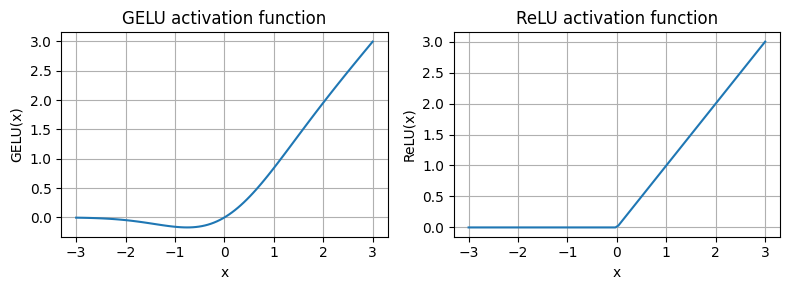

In [43]:
# GELU vs. ReLU

import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))

for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()


# ReLU: piecewise linear function, outputs input directly if it is positive, otherwise outputs zero
# sharp corner at zero, makes optimization harder, esp. in networks that are very deep or have have complex architecture


# GELU: smooth nonlinear function, approximates ReLU but with a non-zero gradient (steepness) for almost all negative values (except at around x=-0.75)
# smoothness leads to better optimization as it allows for more nuanced adjustments to the model's paramters
# allows for a small, non-zero output for negative values. 
# (that means, neurons that receive negative input can still contribute to the learning process, though to a lesser extent than positive inputs)

In [44]:
# input (2-batch size, 3-num of tokens, 768-embedding size)
# the first layer increases the embedding dimension by a factor of 4
# the second layer decreases the embedding dimension by a factor of 4

class FeedForward(nn.Module):
    
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg['emb_dim'], 4 * cfg['emb_dim']),
            GELU(),
            nn.Linear(4 * cfg['emb_dim'], cfg['emb_dim'])
        )
    
    def forward(self, x):
        return self.layers(x)

In [45]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


shortcut/skip/residual connections

In [46]:
class ExampleDeepNeuralNetwork(nn.Module):
    
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])
    
    def forward(self, x):
        
        for layer in self.layers:
            # output of the current layer
            layer_output = layer(x)
            # check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        
        return x

In [47]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=False)

In [48]:
def print_gradients(model, x):
    # forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # calculate loss based on how close the target and output are
    loss = nn.MSELoss()
    loss = loss(output, target)

    # backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [49]:
print_gradients(model_without_shortcut, sample_input)

# vanishing gradient problem: the gradients become smaller as progressing from layer.4 to layer.0

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041653171182
layers.3.0.weight has gradient mean of 0.001398873864673078
layers.4.0.weight has gradient mean of 0.005049646366387606


In [50]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)

In [51]:
print_gradients(model_with_shortcut, sample_input)

# the gradient value stablizes as we progress toward layers.0 and doesn't shrink to a vanishingly small value
# shortcut connections are important for overcoming the limitations posed by the vanishing gradient probelm in deep neural networks
# shortcut connections facilitate more effective training by ensuring consistent gradient flow across layers

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732502937317
layers.4.0.weight has gradient mean of 1.3258541822433472


connecting attention and linear layers in a transformer block

In [52]:
import import_ipynb
from ch3 import MultiHeadAttention

# defines a transformerblock class that inlcudes 
# - multi-head attention mechanism (MultiHeadAttention)
# - feed forward network (FeedFoward)
# - configured based on provided configuration dictionary (cfg), such as GPT_CONFIG_124M

class TransformerBlock(nn.Module):
    
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in = cfg['emb_dim'],
            d_out = cfg['emb_dim'],
            context_length = cfg['context_length'],
            num_heads = cfg['n_heads'],
            dropout = cfg['drop_rate'],
            qkv_bias= cfg['qkv_bias'])
        
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg['emb_dim'])
        self.norm2 = LayerNorm(cfg['emb_dim'])
        self.drop_shortcut = nn.Dropout(cfg['drop_rate'])
    
    def forward(self, x):
        
        # shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        # shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        
        return x 

In [53]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("input shape:", x.shape)
print("output shape:", output.shape)

# transformer architecture pocesses sequences of data without altering their shape throughout the network

input shape: torch.Size([2, 4, 768])
output shape: torch.Size([2, 4, 768])


In [54]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        # embedding layers: convert input tokens indices into dense vectors and adding positional information
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # transformer block: sequential stack of transformerblock meodules equal to the number of layers specified in cfg
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # layer norm: standardizing outputs from the transformer blocks to stabilize the learning process
        self.final_norm = LayerNorm(cfg["emb_dim"])

        # linear output head without bias: projects transformer's output into the vocabulary space of the tokenizer to generate logits
        # logits: for each token in the vocabulary, representing the next token's unnormalized probabilities
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )
    
    # forward method: takes a batch of input token indices, computes their embeddings, applies the positional embeddings, 
    # passes the sequence through the transformer blocks, normalizes the final output
    # computes the logits (representing the next token's unnormalized probabilities)
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        
        return logits

In [55]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOuput shape:", output.shape)
print(out)
# output tensor has shape [2, 4, 50257], given 2 input texts, 4 tokens each, 50257 vocab size of tokenizer

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Ouput shape: torch.Size([2, 4, 768])
tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


In [56]:
total_params = sum(p.numel() for p in model.parameters())
print(f"total number of parameters: {total_params:,}")
# 163mil parameter size

total number of parameters: 163,009,536


In [57]:
print("token embedding layer shape:", model.tok_emb.weight.shape)
print("output layer shape:", model.out_head.weight.shape)

token embedding layer shape: torch.Size([50257, 768])
output layer shape: torch.Size([50257, 768])


In [58]:
total_params_gpt2 = (
    total_params - sum(p.numel()
                       for p in model.out_head.parameters())
)

print(f"number of trainable parameters "
      f"considering weight tying: {total_params_gpt2:,}")

# weight tying: original GPT-2 architecture resuses the weights from the token embedding layer in its output layer.
# reduces the overall memory footprint and computational complexity of the model
# now 124mil parameter large (matching original size of GPT2 model)

number of trainable parameters considering weight tying: 124,412,160


In [59]:
# total size in bytes: assuming float32, 4 bytes per parameter
total_size_bytes = total_params * 4

# converts to megabytes
total_size_mb = total_size_bytes / (1024*1024)
print(f"total size of the model: {total_size_mb: .2f} MB")

# memory requirements: assuming each parameter is a 32-bit float taking up 4 bytes, the total size of the model amounts to 621.83MB
# illustrating the relatively large staorage capacity required to accomodate even relatively small LLMs

total size of the model:  621.83 MB


generating text

In [60]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context

    for _ in range(max_new_tokens):
        # crops current context if it exceeds the supported context size
        # (i.e. if LLM supports only 5 tokens and the context size is 10, only the last 5 tokens are used as context)
        idx_cond = idx[:, -context_size:] 
        
        with torch.no_grad():
            logits = model(idx_cond)
        
        # focus only on the last time step, (batch, n_token, vcab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]
        # probas has shape (batch, vocab_size), softmax to convert logits into probability distribution
        probas = torch.softmax(logits, dim=-1)
        # idx_next has shape (batch, 1), argmax to identify the position with the highest prob value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        # appends sampled index to the runing sequence, where idx has shape (batch, n_tokens+1)
        idx = torch.cat((idx, idx_next), dim=1)
    
    return idx

In [61]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded: ", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0) # adds batch dimension
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded:  [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [62]:
model.eval() # disables dropout since we are not training the model

out = generate_text_simple(model=model, idx=encoded_tensor, max_new_tokens=6, context_size=GPT_CONFIG_124M["context_length"])
print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


In [63]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)
# the reason the model unable to produce coherent text is that we haven't trained it yet
# given we have only implemented the GPT architecture ad initialized a GPT model instance with initial random weights

Hello, I am Featureiman Byeswickattribute argue
